# RES-NET-34 MODEL
## Using Model Subclassing

In [50]:
import os
import cv2
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import Input, Normalization, Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TrueNegatives, TruePositives, Precision, Recall, F1Score, AUC
from tensorflow.keras.regularizers import L2
import sklearn

## Data Preparation

In [51]:
CONFIGURATION = {
    "CLASS_NAMES" : ['angry', 'happy', 'sad'],
    "BATCH_SIZE" : 32,
    "IMAGE_SIZE" : 256,
    "LEARNING_RATE" : 0.01,
    "N_EPOCHS" : 60,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE" : 0.0,
    "N_FILTERS" : 6,
    "KERNEL_SIZE" : 3,
    "N_STRIDES" : 1,
    "POOL_SIZE" : 2,
    "N_DENSE_1" : 128,
    "N_DENSE_2" : 32,
    "NUM_CLASSES" : 3
}

trainDirectory = "/Users/aman/Documents/Work/Machine Learning/Computer-Vision-TensorFlow/Human-Emotions-Detection/Dataset/Emotions Dataset/Emotions Dataset/train"
testDirectory = "/Users/aman/Documents/Work/Machine Learning/Computer-Vision-TensorFlow/Human-Emotions-Detection/Dataset/Emotions Dataset/Emotions Dataset/test"

trainDataset = tf.keras.utils.image_dataset_from_directory(
    trainDirectory,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IMAGE_SIZE"], CONFIGURATION["IMAGE_SIZE"]),
    shuffle=True,
    seed=99,
    validation_split=0.2,
    subset='training',
)

valDataset = tf.keras.utils.image_dataset_from_directory(
    trainDirectory,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IMAGE_SIZE"], CONFIGURATION["IMAGE_SIZE"]),
    shuffle=True,
    seed=99,
    validation_split=0.2,
    subset='validation',
)

testDataset = tf.keras.utils.image_dataset_from_directory(
    testDirectory,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IMAGE_SIZE"], CONFIGURATION["IMAGE_SIZE"]),
    shuffle=True,
    seed=99,
    validation_split=None,
    subset=None,
)

trainDataset = trainDataset.prefetch(tf.data.AUTOTUNE)
testDataset = testDataset.prefetch(tf.data.AUTOTUNE)
valDataset = valDataset.prefetch(tf.data.AUTOTUNE)

Found 6799 files belonging to 3 classes.
Using 5440 files for training.
Found 6799 files belonging to 3 classes.
Using 1359 files for validation.
Found 2278 files belonging to 3 classes.


## ResNet Modeling Using Model Subclassing

In [52]:
class CustomConv2D(tf.keras.layers.Layer):
  def __init__(self, n_filters, kernel_size, n_strides, padding = 'valid'):
    super(CustomConv2D, self).__init__(name = 'custom_conv2d')

    self.conv = Conv2D(
        filters = n_filters,
        kernel_size = kernel_size,
        activation = 'relu',
        strides = n_strides,
        padding = padding)

    self.batch_norm = tf.keras.layers.BatchNormalization()

  def call(self, x, training = True):

    x = self.conv(x)
    x = self.batch_norm(x, training=training)

    return x

In [53]:
class ResidualBlock(tf.keras.layers.Layer):
  def __init__(self, n_channels, n_strides = 1):
    super(ResidualBlock, self).__init__(name = 'res_block')

    self.sizeChanged = (n_strides != 1)

    self.custom_conv_1 = CustomConv2D(n_channels, 3, n_strides, padding = "same")
    self.custom_conv_2 = CustomConv2D(n_channels, 3, 1, padding = "same")

    self.activation = tf.keras.layers.Activation('relu')

    if self.sizeChanged:
      self.custom_conv_3 = CustomConv2D(n_channels, 1, n_strides)

  def call(self, input, training):

    x = self.custom_conv_1(input, training=training)
    x = self.custom_conv_2(x, training=training)

    if self.sizeChanged:
      input = self.custom_conv_3(input, training=training)
      x_added = tf.keras.layers.Add()([x, input])
    else:
      x_added = tf.keras.layers.Add()([x, input])

    return self.activation(x_added)


In [54]:
class ResNet34(tf.keras.models.Model):
  def __init__(self,):
    super(ResNet34, self).__init__(name = 'resnet_34')

    self.conv_1 = CustomConv2D(64, 7, 2, padding = 'same')
    self.max_pool = MaxPooling2D(3,2)

    self.conv_2_1 = ResidualBlock(64)
    self.conv_2_2 = ResidualBlock(64)
    self.conv_2_3 = ResidualBlock(64)

    self.conv_3_1 = ResidualBlock(128, 2)
    self.conv_3_2 = ResidualBlock(128)
    self.conv_3_3 = ResidualBlock(128)
    self.conv_3_4 = ResidualBlock(128)

    self.conv_4_1 = ResidualBlock(256, 2)
    self.conv_4_2 = ResidualBlock(256)
    self.conv_4_3 = ResidualBlock(256)
    self.conv_4_4 = ResidualBlock(256)
    self.conv_4_5 = ResidualBlock(256)
    self.conv_4_6 = ResidualBlock(256)

    self.conv_5_1 = ResidualBlock(512, 2)
    self.conv_5_2 = ResidualBlock(512)
    self.conv_5_3 = ResidualBlock(512)

    self.global_pool = tf.keras.layers.GlobalAveragePooling2D()

    self.fc_3 = tf.keras.layers.Dense(CONFIGURATION["NUM_CLASSES"], activation = 'softmax')

  def call(self, x, training = True):
    x = self.conv_1(x)
    x = self.max_pool(x)

    x = self.conv_2_1(x, training=training)
    x = self.conv_2_2(x, training=training)
    x = self.conv_2_3(x, training=training)

    x = self.conv_3_1(x, training=training)
    x = self.conv_3_2(x, training=training)
    x = self.conv_3_3(x, training=training)
    x = self.conv_3_4(x, training=training)

    x = self.conv_4_1(x, training=training)
    x = self.conv_4_2(x, training=training)
    x = self.conv_4_3(x, training=training)
    x = self.conv_4_4(x, training=training)
    x = self.conv_4_5(x, training=training)
    x = self.conv_4_6(x, training=training)

    x = self.conv_5_1(x, training=training)
    x = self.conv_5_2(x, training=training)
    x = self.conv_5_3(x, training=training)

    x = self.global_pool(x)

    return self.fc_3(x)

In [55]:
resNet34Model = ResNet34()
resNet34Model(tf.zeros([1, 256, 256, 3]), training=True)
resNet34Model.summary()

Model: "resnet_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ custom_conv2d (CustomConv2D)    │ ?                      │         9,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block (ResidualBlock)       │ ?                      │        74,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block (ResidualBlock)       │ ?                      │        74,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block (ResidualBlock)       │ ?                      │        74,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block (ResidualBlock)       │ ?                      │       231,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block (ResidualBlock)       │ ?                      │       296,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block (ResidualBlock)       │ ?                      │       296,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block (ResidualBlock)       │ ?                      │       296,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block (ResidualBlock)       │ ?                      │       921,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block (ResidualBlock)       │ ?                      │     1,182,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block (ResidualBlock)       │ ?                      │     1,182,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block (ResidualBlock)       │ ?                      │     1,182,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block (ResidualBlock)       │ ?                      │     1,182,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block (ResidualBlock)       │ ?                      │     1,182,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block (ResidualBlock)       │ ?                      │     3,677,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block (ResidualBlock)       │ ?                      │     4,723,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ res_block (ResidualBlock)       │ ?                      │     4,723,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_15     │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (1, 3)                 │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,311,747 (81.30 MB)

 Trainable params: 21,294,723 (81.23 MB)

 Non-trainable params: 17,024 (66.50 KB)

In [56]:
# Defining Model Checkpointing Callback
modelCheckpointingCallback = tf.keras.callbacks.ModelCheckpoint(
    "ModelCheckpoints/Checkpoints.keras",
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True, # Will save only the best one
    save_weights_only=False, # Model v/s Weights
    mode='max',
    save_freq='epoch', # Saves after
)

In [57]:
lossFunction = tf.keras.losses.CategoricalCrossentropy()

In [58]:
METRICS = [tf.keras.metrics.CategoricalAccuracy(name="accuracy"), tf.keras.metrics.TopKCategoricalAccuracy(k=2, name="top_k_accuracy")]

In [59]:
resNet34Model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=CONFIGURATION["LEARNING_RATE"]),
    loss = lossFunction,
    metrics=METRICS
)

In [60]:
history = resNet34Model.fit(
    trainDataset,
    validation_data = valDataset,
    epochs = CONFIGURATION['N_EPOCHS'],
    verbose=1,
    callbacks = [modelCheckpointingCallback]
)

Epoch 1/60
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step - accuracy: 0.4095 - loss: 1.9281 - top_k_accuracy: 0.7334
Epoch 1: val_accuracy improved from -inf to 0.34143, saving model to ModelCheckpoints/Checkpoints.keras
170/170 ━━━━━━━━━━━━━━━━━━━━ 109s 525ms/step - accuracy: 0.4096 - loss: 1.9250 - top_k_accuracy: 0.7335 - val_accuracy: 0.3414 - val_loss: 24.1748 - val_top_k_accuracy: 0.5997
Epoch 2/60
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - accuracy: 0.4753 - loss: 1.1444 - top_k_accuracy: 0.7552
Epoch 2: val_accuracy improved from 0.34143 to 0.51803, saving model to ModelCheckpoints/Checkpoints.keras
170/170 ━━━━━━━━━━━━━━━━━━━━ 87s 512ms/step - accuracy: 0.4753 - loss: 1.1443 - top_k_accuracy: 0.7553 - val_accuracy: 0.5180 - val_loss: 1.2799 - val_top_k_accuracy: 0.8035
Epoch 3/60
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - accuracy: 0.5267 - loss: 1.0619 - top_k_accuracy: 0.7863
Epoch 3: val_accuracy did not improve from 0.51803
170/170 ━━━━━━━━━━━━━━━━━━━━ 90s 528ms/step - acc

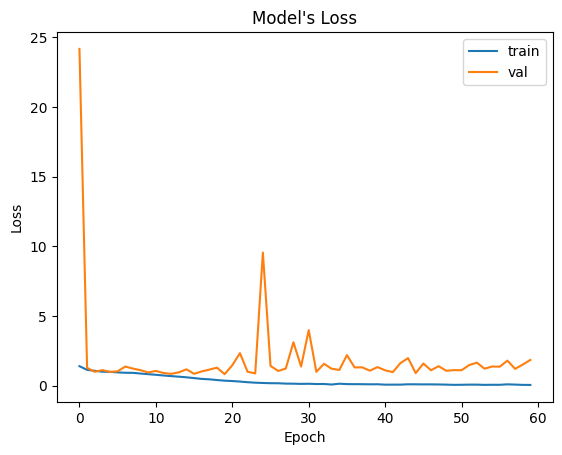

In [65]:
# PLotting the model's loss graph for both training and validation
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model's Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["train", "val"])
plt.show()

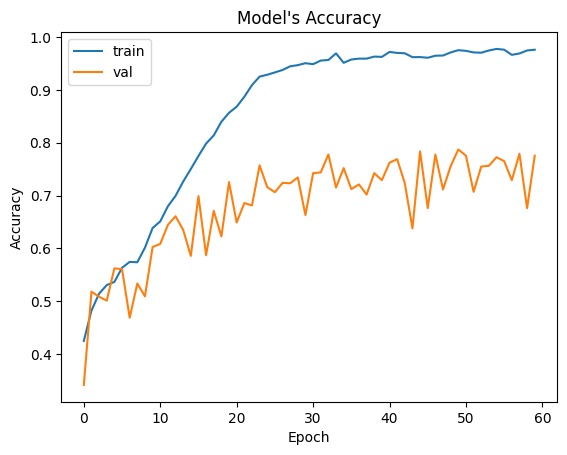

In [66]:
# PLotting the model's accuracy graph for both training and validation
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model's Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["train", "val"])
plt.show()

In [67]:
resNet34Model.load_weights("ModelCheckpoints/Checkpoints.keras")

In [68]:
resNet34Model.evaluate(testDataset)

72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.7600 - loss: 1.3484 - top_k_accuracy: 0.9337


[1.2935340404510498, 0.7594380974769592, 0.9302019476890564]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


2025-01-29 22:15:03.385933: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


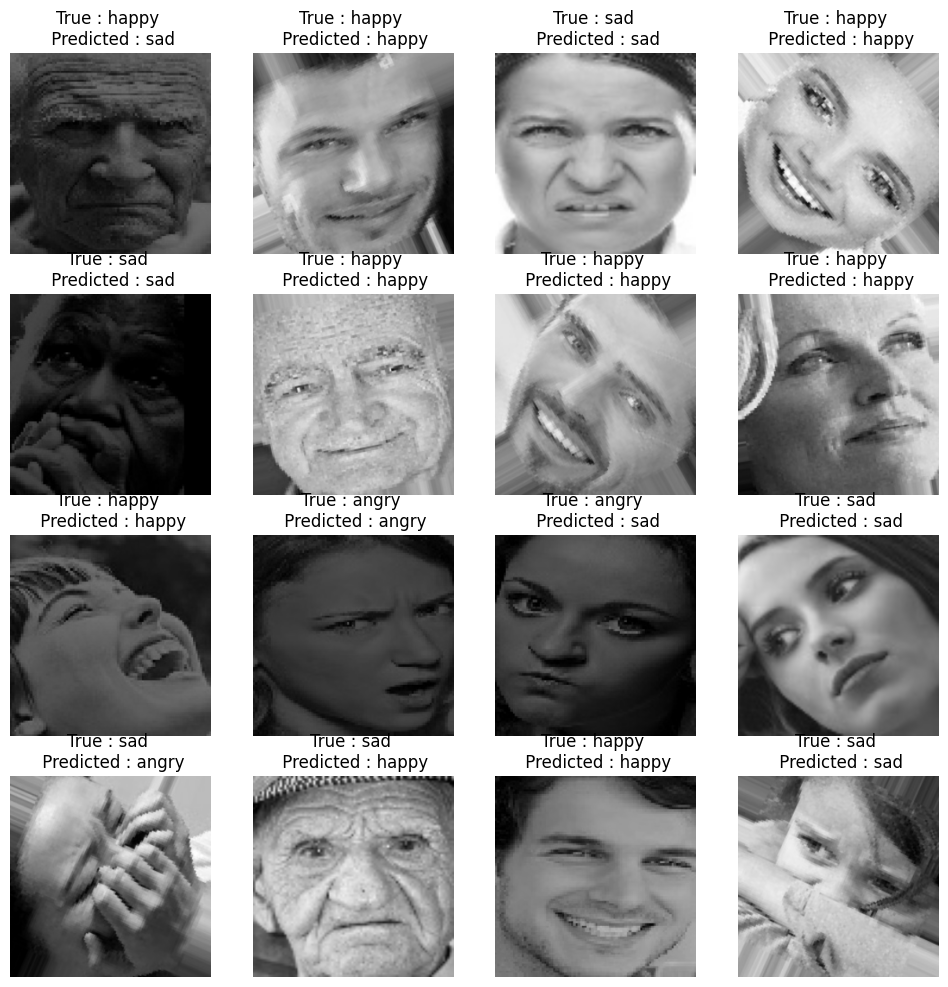

In [69]:
# Testing 1 Batch
plt.figure(figsize=(12, 12))

for images, labels in testDataset.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i+1)
        plt.imshow(images[i]/255.0)
        prediction = resNet34Model.predict(tf.expand_dims(images[i], axis=0))
        true = CONFIGURATION["CLASS_NAMES"][tf.argmax(labels[i], axis=0).numpy()]
        predicted = CONFIGURATION["CLASS_NAMES"][tf.argmax(prediction, axis=-1).numpy()[0]]
        plt.title("True : {} \n Predicted : {}".format(true, predicted))
        plt.axis("off")

In [70]:
labels = []
predicted = []
for image, label in valDataset:
    predicted.append(resNet34Model.predict(image, verbose=0))
    labels.append(label.numpy())

2025-01-29 22:16:09.142242: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [71]:
pred = np.argmax(predicted[:-1], axis=-1).flatten()
true = np.argmax(labels[:-1], axis=-1).flatten()
print(pred, true)

[2 1 2 ... 1 1 0] [2 1 0 ... 1 1 0]


[[167  42  87]
 [ 25 521  51]
 [ 32  50 369]]


Text(0.5, 36.72222222222221, 'Predicted')

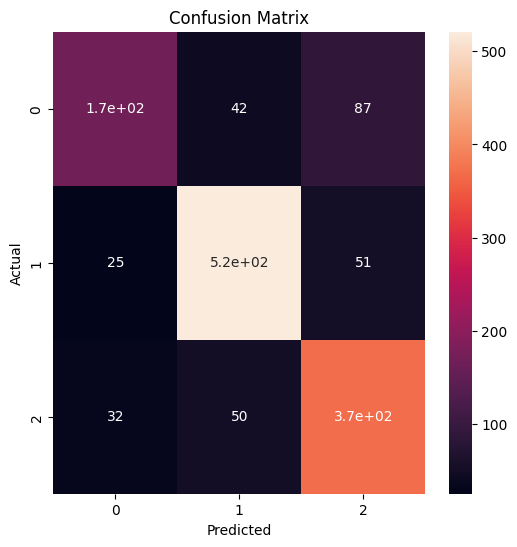

In [72]:
cm = sklearn.metrics.confusion_matrix(true, pred)
print(cm)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')